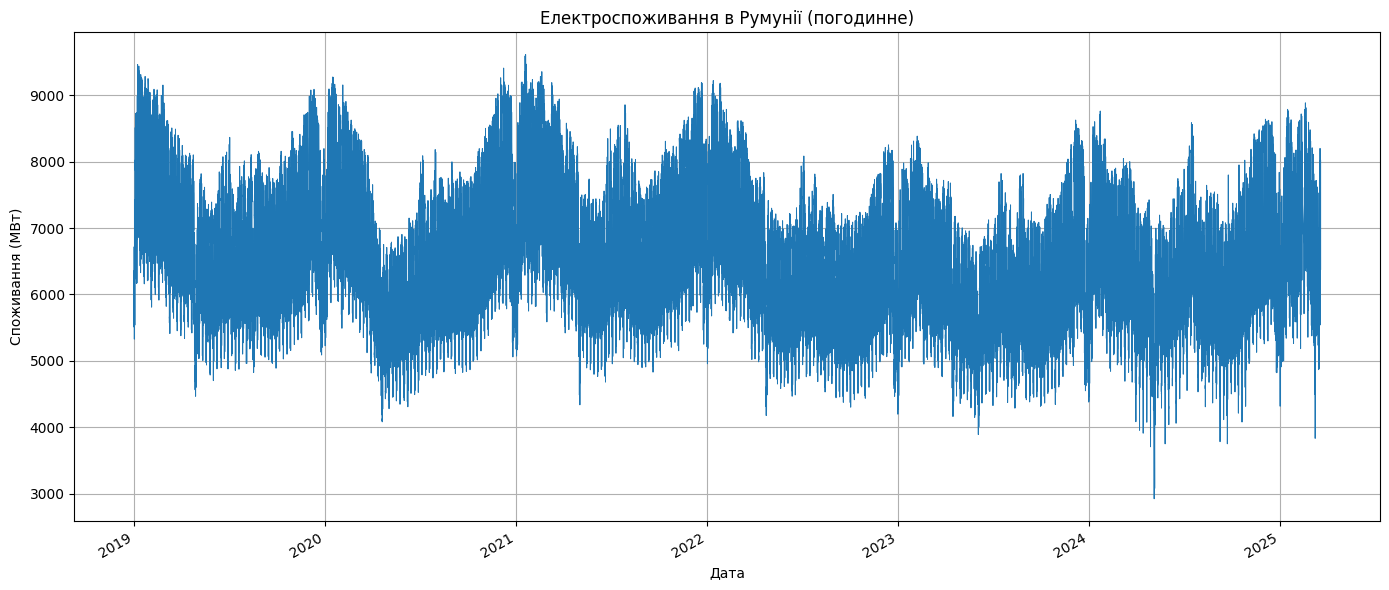

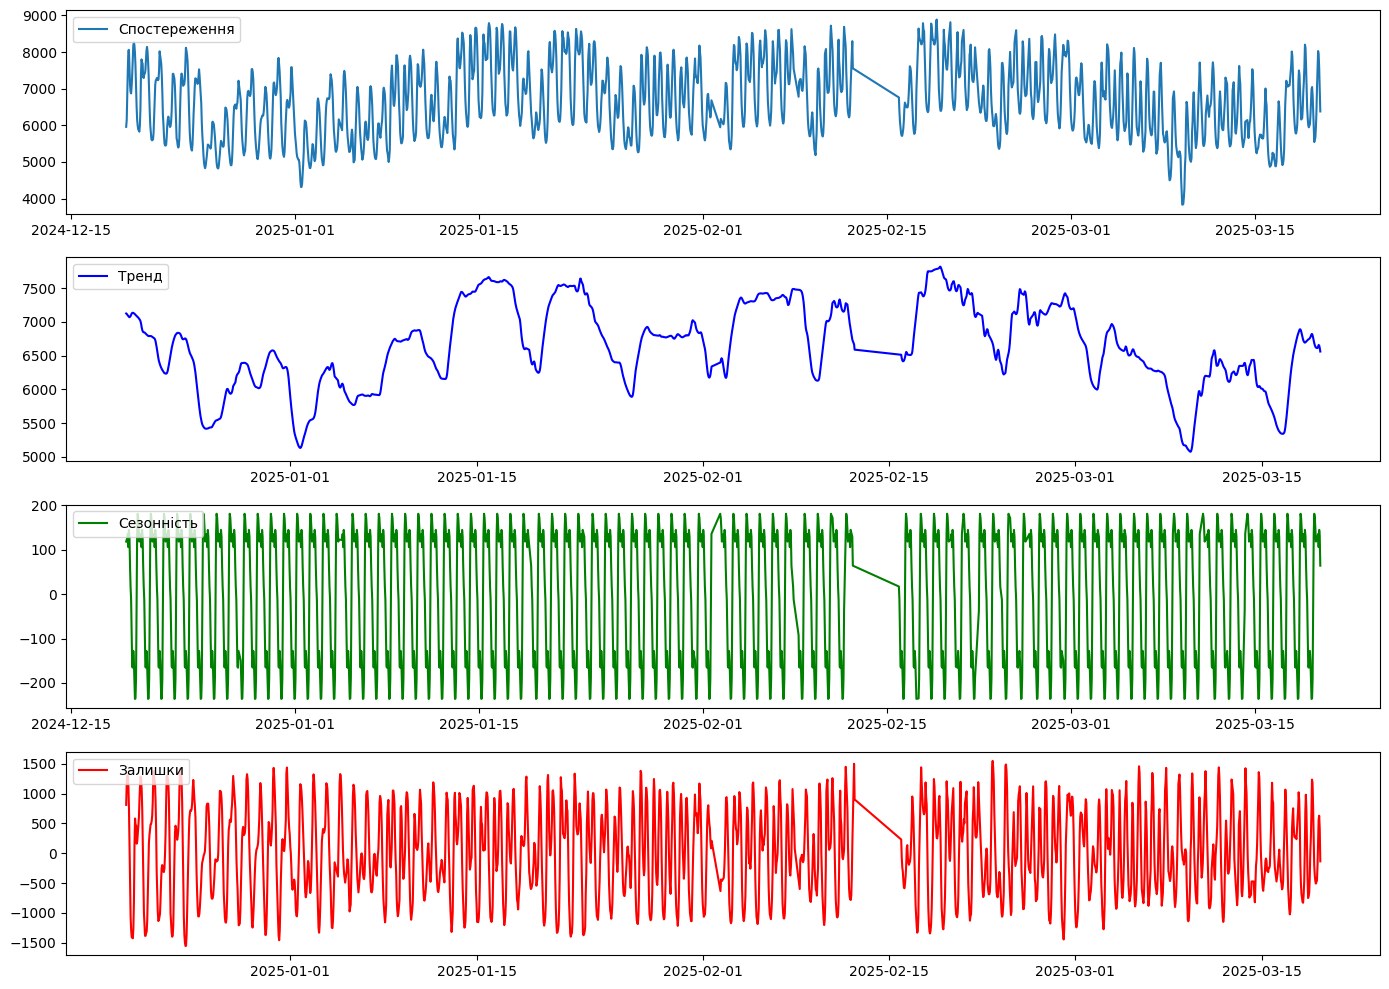

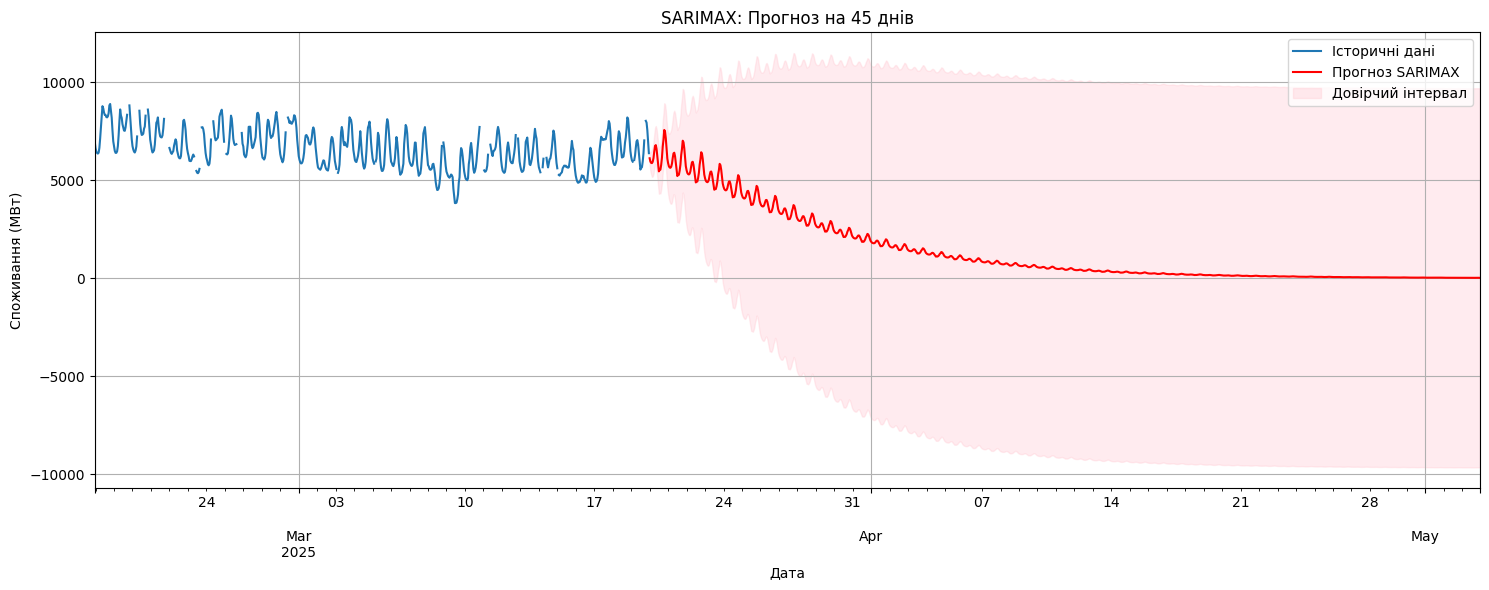

13:38:10 - cmdstanpy - INFO - Chain [1] start processing
13:38:10 - cmdstanpy - INFO - Chain [1] done processing


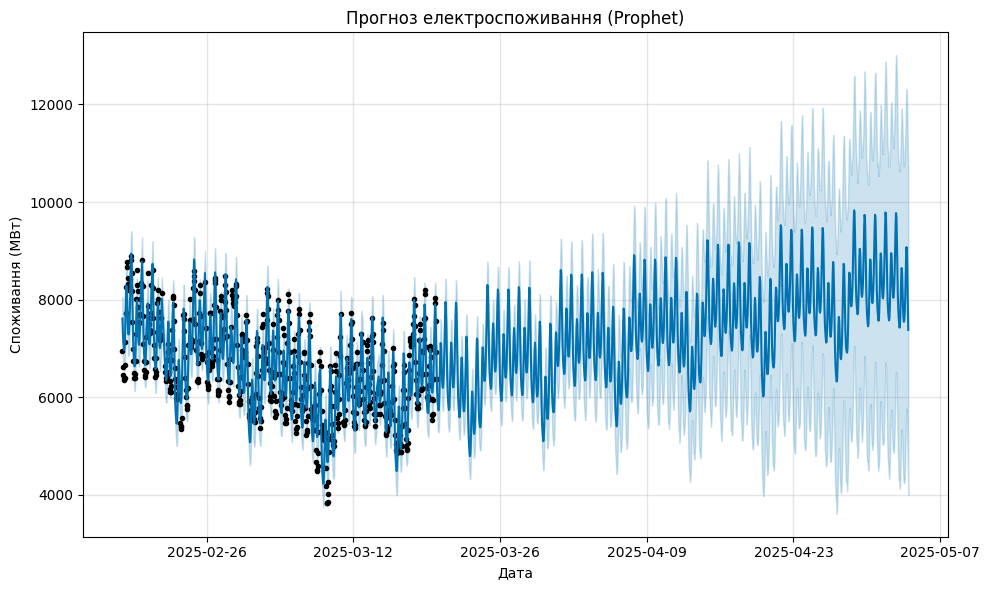

C:\Users\Oleg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Oleg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Oleg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Oleg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Oleg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739

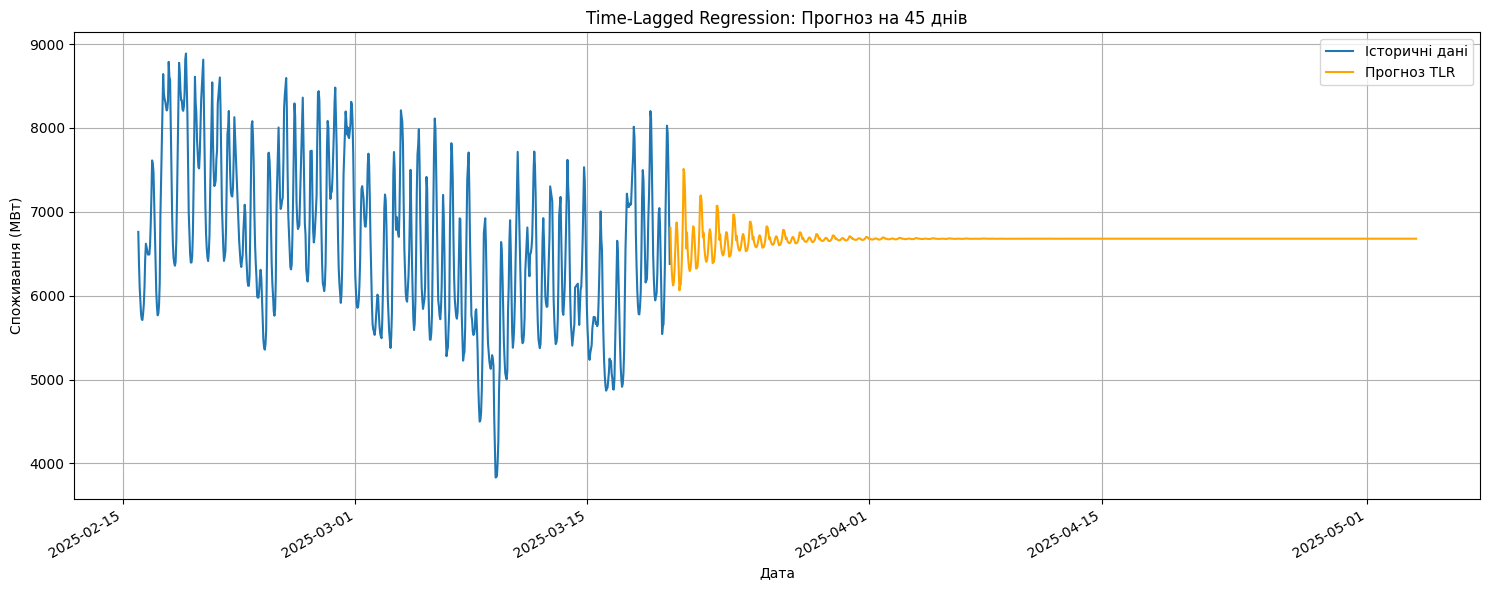

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'C:\Users\Oleg\Desktop\Amazinm Upt\task_23\task_23\autogluon_chronos'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
CPU Count:          12
GPU Count:          0
Memory Avail:       6.81 GB / 15.95 GB (42.7%)
Disk Space Avail:   101.55 GB / 464.95 GB (21.8%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'H',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1080,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Provided train_data has 54480 rows (NaN fraction=0.6%), 

	-0.0689       = Validation score (-WQL)
	14.94   s     = Training runtime
	7.11    s     = Validation (prediction) runtime
Training timeseries model ChronosFineTuned[bolt_small]. Training for up to 74.3s of the 445.7s of remaining time.
	Skipping covariate_regressor since the dataset contains no covariates or static features.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to C:\Users\Oleg\Desktop\Amazinm Upt\task_23\task_23\autogluon_chronos\models\ChronosFineTuned[bolt_small]\W0\fine-tuned-ckpt
	-0.0702       = Validation score (-WQL)
	61.29   s     = Training runtime
	1.58    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 76.6s of the 382.9s of remaining time.
	-0.1026       = Validation score (-WQL)
	73.09   s     = Training runtime
	0.25    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 77.4s of the 3

Chronos forecast columns: Index(['mean', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'], dtype='object')


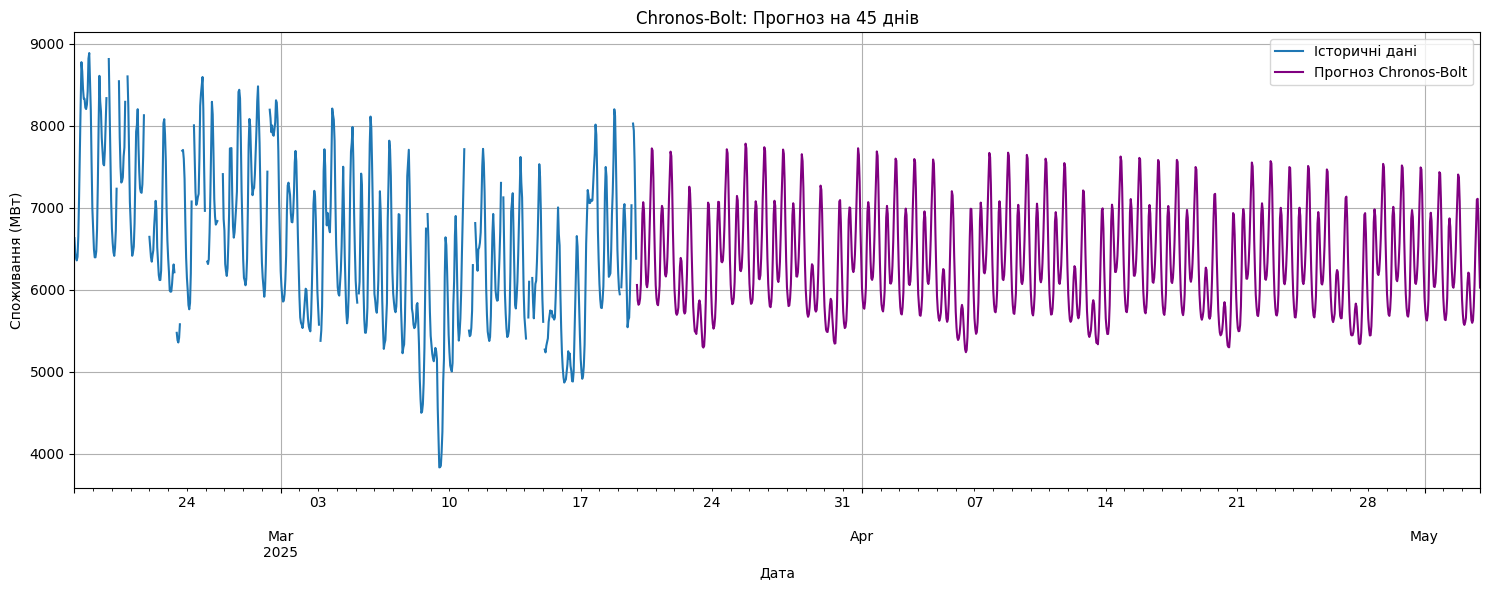

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX as sar
from prophet import Prophet as proph
from sklearn.linear_model import LinearRegression
import numpy as np
class tsk_23 :
    def __init__(self):
        dt_patch = "electricity_consumption_and_production.csv"
        self.df = pd.read_csv(dt_patch)

    def DT_predict(self):
        self.df["DateTime"] = pd.to_datetime(self.df["DateTime"])
        self.df.set_index("DateTime", inplace=True)

    def viz_tm (self):
        plt.figure(figsize=(14, 6))
        self.df["Consumption"].plot(title="Електроспоживання в Румунії (погодинне)", linewidth=0.7)
        plt.xlabel("Дата")
        plt.ylabel("Споживання (МВт)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def consumption (self):
        df_subset = self.df["Consumption"].iloc[-2000:]
        decompose = seasonal_decompose(df_subset, model='additive', period=24)
        plt.figure(figsize=(14, 10))
        plt.subplot(411)
        plt.plot(decompose.observed, label="Спостереження")
        plt.legend(loc='upper left')
        plt.subplot(412)
        plt.plot(decompose.trend, label="Тренд", color='blue')
        plt.legend(loc='upper left')
        plt.subplot(413)
        plt.plot(decompose.seasonal, label="Сезонність", color='green')
        plt.legend(loc='upper left')
        plt.subplot(414)
        plt.plot(decompose.resid, label="Залишки", color='red')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

    def sarimax_lt(self):
        last_30_days = self.df.loc[self.df.index >= self.df.index.max() - pd.Timedelta(days=30)]
        self.train_dt = last_30_days["Consumption"]
        self.train_dt = self.train_dt.asfreq("H")
        model = sar(self.train_dt, order=(1, 0, 0), seasonal_order=(1, 0, 0, 24)) #лайт модель
        results = model.fit(disp=False)
        forecast = results.get_forecast(steps=1080)
        self.forecast_mean = forecast.predicted_mean
        self.conf_int = forecast.conf_int()

    def sarimax_viz(self):
        forecast_index = pd.date_range(
            start=self.train_dt.index[-1] + pd.Timedelta(hours=1),
            periods=1080,
            freq="H"
        )

        forecast_series = pd.Series(self.forecast_mean.values, index=forecast_index)

        plt.figure(figsize=(15, 6))
        self.train_dt.plot(label="Історичні дані")
        forecast_series.plot(label="Прогноз SARIMAX", color="red")

        plt.fill_between(
            forecast_index,
            self.conf_int.iloc[:, 0],
            self.conf_int.iloc[:, 1],
            color="pink",
            alpha=0.3,
            label="Довірчий інтервал"
        )

        plt.xlabel("Дата")
        plt.ylabel("Споживання (МВт)")
        plt.title("SARIMAX: Прогноз на 45 днів")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def prophet(self):
        df_prophet = self.df.reset_index()[["DateTime", "Consumption"]]
        df_prophet = df_prophet.rename(columns={"DateTime": "ds", "Consumption": "y"})
        df_prophet = df_prophet[df_prophet["ds"] >= df_prophet["ds"].max() - pd.Timedelta(days=30)]
        model = proph(daily_seasonality=True, weekly_seasonality=True)
        model.fit(df_prophet)
        future = model.make_future_dataframe(periods=1080, freq='H')
        forecast = model.predict(future)
        self.prophet_model = model
        self.prophet_forecast = forecast
        self.df_prophet = df_prophet

    def prophet_viz(self):
        self.prophet_model.plot(self.prophet_forecast)
        plt.title("Прогноз електроспоживання (Prophet)")
        plt.xlabel("Дата")
        plt.ylabel("Споживання (МВт)")
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    def lagged_reg(self):
        from sklearn.preprocessing import StandardScaler

        df = self.df.copy()
        df = df[df.index >= df.index.max() - pd.Timedelta(days=60)]
        df = df[["Consumption"]]

        scaler = StandardScaler()
        df["Consumption_scaled"] = scaler.fit_transform(df[["Consumption"]])

        for lag in [24, 48, 72]:
            df[f"lag_{lag}"] = df["Consumption_scaled"].shift(lag)

        df.dropna(inplace=True)

        X = df[["lag_24", "lag_48", "lag_72"]]
        y = df["Consumption_scaled"]

        model = LinearRegression()
        model.fit(X, y)

        recent_values = df["Consumption_scaled"].values[-72:].tolist()
        last_timestamp = df.index[-1]

        preds_scaled = []
        forecast_index = []

        for _ in range(1080):
            lag_24 = recent_values[-24]
            lag_48 = recent_values[-48]
            lag_72 = recent_values[-72]

            x_vec = np.array([[lag_24, lag_48, lag_72]])
            y_pred_scaled = model.predict(x_vec)[0]

            preds_scaled.append(y_pred_scaled)

            recent_values.append(y_pred_scaled)
            recent_values.pop(0)

            last_timestamp += pd.Timedelta(hours=1)
            forecast_index.append(last_timestamp)

        preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

        self.lag_forecast = pd.Series(preds, index=forecast_index)
        self.lag_train = df["Consumption"]

    def lagged_viz(self):
        plt.figure(figsize=(15, 6))
        self.lag_train[-720:].plot(label="Історичні дані")
        self.lag_forecast.plot(label="Прогноз TLR", color="orange")
        plt.title("Time-Lagged Regression: Прогноз на 45 днів")
        plt.xlabel("Дата")
        plt.ylabel("Споживання (МВт)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def chronos_bolt(self):
        from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

        df_ts = self.df[["Consumption"]].copy()
        df_ts = df_ts.reset_index().rename(columns={"DateTime": "timestamp", "Consumption": "target"})
        df_ts["item_id"] = "electricity"
        df_ts = df_ts[["item_id", "timestamp", "target"]]

        ts_data = TimeSeriesDataFrame(df_ts).convert_frequency("H")

        predictor = TimeSeriesPredictor(
            prediction_length=1080,
            path="autogluon_chronos",
            freq="H"
        )

        predictor.fit(
            ts_data,
            time_limit=600,  # до 10 хв
            presets="high_quality"
        )

        forecast = predictor.predict(ts_data)

        self.chronos_forecast = forecast.loc["electricity"]
        self.chronos_train = ts_data.loc["electricity"]["target"]

    def chronos_viz(self):
        import matplotlib.pyplot as plt

        plt.figure(figsize=(15, 6))

        self.chronos_train[-720:].plot(label="Історичні дані")

        print("Chronos forecast columns:", self.chronos_forecast.columns)

        if 'mean' in self.chronos_forecast.columns:
            pred_series = self.chronos_forecast['mean']
        elif 0.5 in self.chronos_forecast.columns:
            pred_series = self.chronos_forecast[0.5]
        else:
            pred_series = self.chronos_forecast.iloc[:, 0]  # fallback: перша колонка

        pred_series.plot(label="Прогноз Chronos-Bolt", color="purple")

        plt.title("Chronos-Bolt: Прогноз на 45 днів")
        plt.xlabel("Дата")
        plt.ylabel("Споживання (МВт)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


proj_start = tsk_23()
proj_start.DT_predict()
proj_start.viz_tm()
proj_start.consumption()
proj_start.sarimax_lt()
proj_start.sarimax_viz()
proj_start.prophet()
proj_start.prophet_viz()
proj_start.lagged_reg()
proj_start.lagged_viz()
proj_start.chronos_bolt()
proj_start.chronos_viz()